# Analytical Upwelling Model

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sympy as sp
import cmocean
import gsw
import os

from salishsea_tools import viz_tools, tidetools, grid_tools

%matplotlib inline

plt.rcParams['font.size'] = 18
plt.rcParams['contour.negative_linestyle'] = 'solid'

In [12]:
figpath = '/ocean/bmoorema/research/documents/presentations/LaTeX/CMOS2018/figures'

In [11]:
def make_domain_diagram(E=0.1, M=0.3, S=1.0):
    """Quick plotting code for a domain diagram
    """
    
    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, S])
    
    # Add labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.xaxis.set_ticks([0])
    ax.yaxis.set_ticks([0, M, S])
    ax.yaxis.set_ticklabels([0, 'M', 'S'])
    ax.tick_params(direction='out', pad=8)
    ax.text(-0.07, M/2-0.01, 'Cape')
    #ax.text(1.01, S-0.01, 'Shelfbreak')
    
    # Add coastline ticks
    for tick in np.arange(0, 1, 0.01):
        ax.plot([tick, tick+0.01], [0, -0.02], 'k-', clip_on=False)
    for tick in np.arange(0, M, 0.03):
        ax.plot([-0.008, 0], [tick, tick+0.02], 'k-', clip_on=False)
        
    # Display SSH sink lengthscale
    ax.plot([0, 1], [E, E], 'k--')
    ax.text(1.01, E-0.01, 'E')
    
    return fig, ax

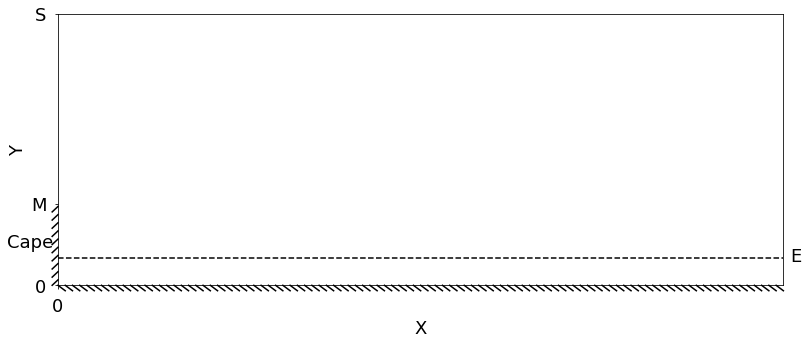

In [16]:
fig, ax = make_domain_diagram()
fig.savefig(os.path.join(figpath, 'cape_diagram.pdf'), dpi=300, bbox_inches='tight')

### Shallow water free surface equations for upwelling along a coastline

From Allen (1996), *JPO*:

The linear barotropic shallow water equations excluding the surface layer are

$$\begin{align}
\frac{\partial \mathbf{u}}{\partial t} + f\mathbf{k} \times \mathbf{u} & = -g\nabla\eta \tag{1a} \\
\frac{\partial \eta}{\partial t} + \nabla\cdot\left(h\mathbf{u}\right) & = -q \tag{1b}
\end{align}$$

where $q$ is the sea surface height sink due to Ekman pumping within a lengthscale $E$, given by

$$q =
  \begin{cases}
    q_0,  & \quad y > E\\
    0,    & \quad y < E
  \end{cases} \tag{2}
$$

and $q_0 = \tau/\rho_0Ef$. A potential vorticity conservation equation can be derived

$$\frac{\partial}{\partial t}\left(h\nabla \times \mathbf{u} - f\eta\right) = f\mathbf{u}\cdot\nabla h + fq \tag{3}$$

Substituting constant and time-dependent solutions $\eta = \eta_1ft + \eta_0$, $u = u_1ft + u_0$, and $v = v_1ft + v_0$ into (1) and (3) gives, away from topographic changes

$$\begin{align}
a^2\nabla^2\eta_1 - \eta_1 & = \frac{q}{f} \tag{9} \\
a^2\nabla^2\eta_0 - \eta_0 & = 0 \tag{10}
\end{align}$$

where $a = \sqrt{gh}/f$ is the barotropic Rossby radius.

### Solution in absence of a cape

In the absence of a cape, (9) is $x$-independent and reduces to

$$\frac{gh}{f^2}\frac{\partial^2 \bar{\eta_1}(y)}{\partial y^2} - \bar{\eta_1}(y) = \frac{q}{f} \tag{A2}$$

Boundary conditions are

$$\begin{align}
& \frac{\partial \bar{\eta_1}(0)}{\partial y} = 0 \hspace{0.5cm} \text{(no flow along coastal boundary)} \tag{A3a} \\
& \bar{\eta_1}(E), \hspace{0.3cm} \frac{\partial \bar{\eta_1}(E)}{\partial y} \hspace{0.5cm} \text{continuous} \tag{A3b} \\
& \bar{\eta_1}(S), \hspace{0.3cm} h\frac{\partial \bar{\eta_1}(S)}{\partial y} \hspace{0.5cm} \text{continuous} \tag{A3c} \\
& \lim_{y \to \infty} \bar{\eta_1}(y) = 0 \hspace{0.5cm} \text{($\eta$ decays far from coast)} \tag{A3d}
\end{align}$$

The solution to (A2) given the boundary conditions (A3) is

$$\bar{\eta_1}(y) =
\begin{cases}
\frac{q_0}{f}\left(\frac{\alpha\sinh\left(\frac{S - E}{a_s}\right) + \cosh\left(\frac{S - E}{a_s}\right)}{\alpha\sinh\left(\frac{S}{a_s}\right) + \cosh\left(\frac{S}{a_s}\right)}\right)\cosh\left(\frac{y}{a_s}\right) - \frac{q_0}{f},  & \quad y < E \\
-\frac{q_0}{f}\left(\frac{\sinh\left(\frac{E}{a_s}\right)}{\alpha\sinh\left(\frac{S}{a_s}\right) + \cosh\left(\frac{S}{a_s}\right)}\right)\left[\alpha\cosh\left(\frac{S - y}{a_s}\right) + \sinh\left(\frac{S - y}{a_s}\right)\right],  & \quad E < y < S
\end{cases} \tag{A4}
$$

The calculation is shown below

In [4]:
def calc_eta_bar(y):
    """
    """
    
    eta_bar = -q_0 / f * np.sinh(E / R) / bot * (alpha * np.cosh((S - y) / R) + np.sinh((S - y) / R))
    eta_bar[y <= E] = q_0 / f * (top / bot * np.cosh(y[y <= E] / R) - 1)
    
    return eta_bar

In [5]:
# Physical parameters
g = 9.81      # Gravitational acceleration   [m/s2]
f = 1e-4      # Coriolis parameter           [1/s]
rho_0 = 1.2e3 # Background density           [kg/m3]
drho = 10     # Interface density difference [kg/m3]
tau = 0.1     # Windstress                   [N/m2]
H_u = 20      # Depth of upper layer         [m]
H_s = 50      # Depth over shelf             [m]
H_d = 5e2     # Depth beyond shelfbreak      [m]

# Domain parameters
S = 1e4       # Shelf width                  [m]
E = 1e3       # Upwelling lengthscale        [m]

# Calculate terms
R = np.sqrt(g * drho/rho_0 * H_u * (H_s - H_u) / H_s) / f  # Rossby radius [m]
alpha = np.sqrt(H_s / H_d)           # Depth ratio
q_0 = tau / (rho_0 * E * f)          # Ekman pumping [m/s]

# Primary cosh and sinh terms
top = alpha * np.sinh((S - E) / R) + np.cosh((S - E) / R)
bot = alpha * np.sinh(S / R) + np.cosh(S / R)

# Make y array
y = np.arange(0, S, 10)

# Calculate eta_bar
eta_bar = calc_eta_bar(y)

And plotted

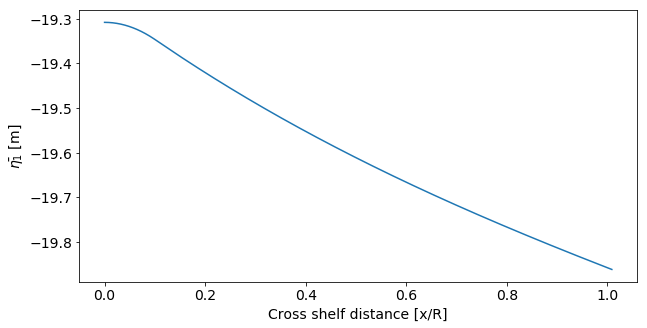

In [6]:
# Plot eta_bar
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(y / R, -(H_u + eta_bar))
ax.set_xlabel('Cross shelf distance [x/R]')
ax.set_ylabel('$\\bar{\eta_1}$ [m]')

plt.show()

### Solution of time-varying component

The full solution to (9) can be decomposed into a particular solution given by $\bar{\eta_1}(y)$ and a homogeneous solution $\phi$

$$\eta_1 = \bar{\eta_1}(y) + \phi \tag{12}$$

where $\phi$ satisfies the equation

$$R^2\nabla^2\phi - \phi = 0 \tag{13}$$

Boundary conditions are

$$
\begin{align}
\phi(x, 0) = \phi(x, S) & = 0 \hspace{0.5cm} \text{($x$-independent at coast and shelfbreak)} \tag{14a} \\
\lim_{x \to \infty}\phi & = 0 \hspace{0.5cm} \text{($x$-independent away from cape)} \tag{14b} \\
\phi(0, [0, M]) & = \bar{\eta_1}(0) - \bar{\eta_1}(y) \hspace{0.5cm} \text{(no flow through cape)} \tag{14c} \\
\frac{\partial}{\partial x}\phi(0, [M, S]) & = 0 \hspace{0.5cm} \text{(flow around cape is symmetric)} \tag{14d}
\end{align}
$$

The general solution to (13) given the $y$ boundary conditions (14a and b) is

$$\phi = \sum_{n=1}^\infty c_n\exp\left\{-x\left[\frac{1}{R^2} + \left(\frac{n\pi}{S}\right)^2\right]^{1/2}\right\}\sin\left(\frac{n\pi y}{S}\right) \tag{15, 16}$$

Applying the $x = 0$ boundary conditions

$$
\begin{align}
\phi(0, y) = & \sum_{n=1}^\infty c_n\sin\left(\frac{n\pi y}{S}\right) = \bar{\eta_1}(0) - \bar{\eta_1}(y) & \hspace{0.2cm} \text{for } y = [0, M] \\
\frac{\partial}{\partial x}\phi(0, y) = & \sum_{n=1}^\infty -c_n\left[\frac{1}{R^2} + \left(\frac{n\pi}{S}\right)^2\right]^{1/2}\sin\left(\frac{n\pi y}{S}\right) = 0 & \hspace{0.2cm} \text{for } y = [M, S]
\end{align}$$

Now we calculate phi and eta

In [7]:
# Parameters
N = 1000
M = S/2

# Define x, y and n arrays
y_n = np.arange(1, N + 1) / N * S
n = np.arange(1, N + 1, dtype=int)
ni, y_ni = np.meshgrid(n, y_n)

# Indices
yindex = y_n <= M

# Allocate matrix A and RHS
A = np.zeros([N, N])
RHS = np.zeros([N, 1])

# Populate A matrix
A[yindex, :] = np.sin(ni[yindex, :] * np.pi * y_ni[yindex, :] / S)
A[~yindex, :] = -np.sqrt(1 / R**2 + (ni[~yindex, :] * np.pi / S)**2) * np.sin(ni[~yindex, :] * np.pi * y_ni[~yindex, :] / S)

# Populate RHS
RHS[yindex, 0] = calc_eta_bar(np.array([0])) - calc_eta_bar(y_n[yindex])

# Solve for C coefficients
C = np.linalg.solve(A, RHS)

# Calculate phi
x = np.arange(0, 1e4, 10)
xi, yi = np.meshgrid(x, y)
phi = np.zeros(xi.shape)
for n, C_n in zip(range(1, N + 1), C):
    phi = phi + C_n * np.exp(-xi * np.sqrt(1 / R**2 + (n * np.pi / S)**2)) * np.sin(n * np.pi * yi / S)

# Calculate eta
eta_bar = calc_eta_bar(yi)
eta = phi + eta_bar
eta_grad = np.gradient(eta)
eta_bar_grad = np.gradient(eta_bar)

And plot

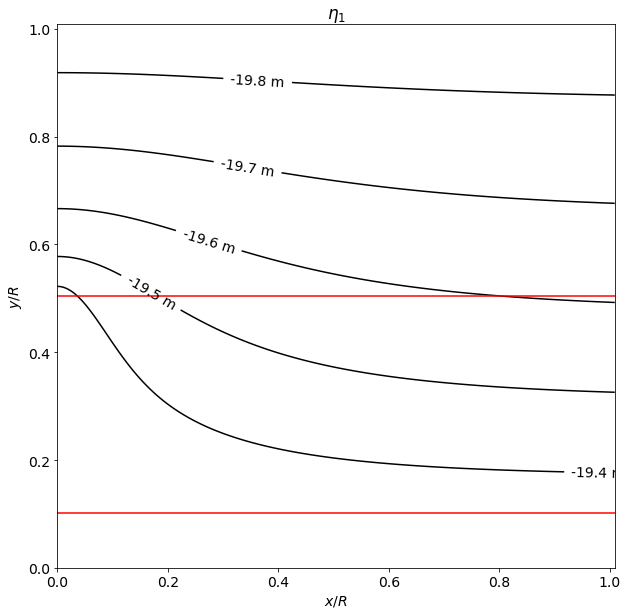

In [9]:
# Plot eta
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
c = ax.contour(x/R, y/R, -(H_u + eta), colors='k', levels=np.arange(-20, -19.3, 0.1))
ax.clabel(c, fmt='%.1f m')
ax.plot([0, 1e4/R], [M/R, M/R], 'r')
ax.plot([0, 1e4/R], [E/R, E/R], 'r')
ax.set_xlim([0, 1e4/R])
ax.set_xlabel('$x/R$')
ax.set_ylabel('$y/R$')
ax.set_title('$\eta_1$')

plt.show()

From substitution into (1a) we have proportial to $t$

$$f\mathbf{k} \times \mathbf{u_1} = -g\nabla\eta_1 \tag{4a}$$

and the steady balance

$$f\mathbf{u_1} + f\mathbf{k} \times \mathbf{u_0} = -g\nabla\eta_0 \tag{5a}$$

The ageostrophic part of the steady velocity $\mathbf{u_0}$ is then

$$f\mathbf{u_1} + f\mathbf{k} \times \mathbf{u_s} = 0 \tag{7}$$

which gives the ageostrophic velocity $\mathbf{u_s}$ perpendicular to the streamfunction $\eta_1$

$$\mathbf{u_s} = \frac{-g}{f}\nabla\eta_1$$

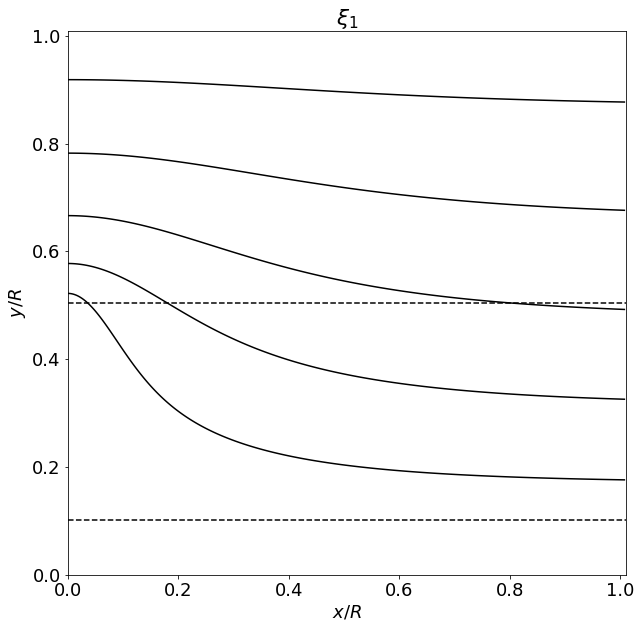

In [34]:
# Plot eta
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#cs = ax.contourf(x/R, y/R, np.sqrt(eta_grad[0]**2 + eta_grad[1]**2)/0.004, levels=np.arange(0, 1.1, 0.1), cmap=cmocean.cm.amp, extend='both')
#ax.quiver(x[::100]/R, y[::100]/R, -g/f*eta_bar_grad[1][::100, ::100], -g/f*eta_bar_grad[0][::100, ::100], color='gray', scale=1e3)
#ax.quiver(x[::100]/R, y[::100]/R, -g/f*eta_grad[1][::100, ::100], -g/f*eta_grad[0][::100, ::100], scale=1.5e3)
#ax.quiver(
#    x[::100]/R, y[::100]/R,
#    -g/f*(eta_grad[1][::100, ::100] - eta_bar_grad[1][::100, ::100]),
#    -g/f*(eta_grad[0][::100, ::100] - eta_bar_grad[0][::100, ::100]),
#    color='r', scale=1e3,
#)
c = ax.contour(x/R, y/R, -(H_u + eta), colors='k', levels=np.arange(-20, -19.3, 0.1))
#ax.clabel(c, fmt='%.1f m')
ax.plot([0, 1e4/R], [M/R, M/R], 'k--')
ax.plot([0, 1e4/R], [E/R, E/R], 'k--')
ax.set_xlim([0, 1e4/R])
ax.set_xlabel('$x/R$')
ax.set_ylabel('$y/R$')
ax.set_title('$\\xi_1$')

#cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
#fig.colorbar(cs, cax=cax, label='$\|\\nabla\\xi\|$ [m]')

fig.savefig(os.path.join(figpath, 'xi.pdf'), dpi=300, bbox_inches='tight')

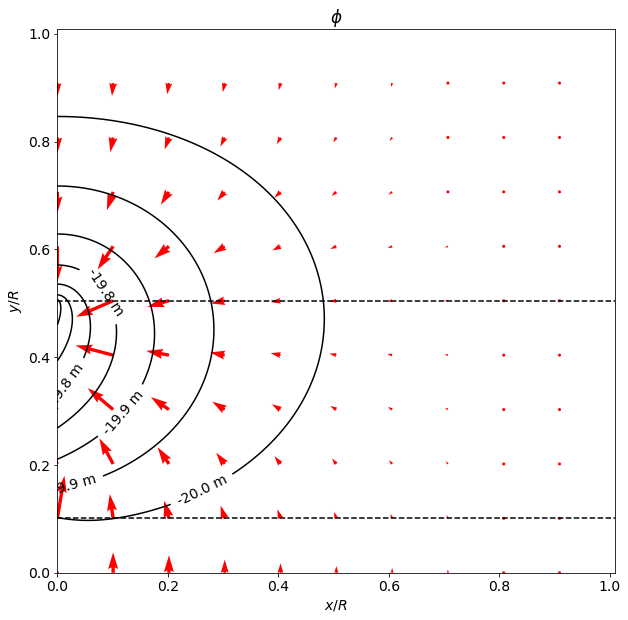

In [11]:
# Plot phi
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.quiver(
    x[::100]/R, y[::100]/R,
    -g/f*(eta_grad[1][::100, ::100] - eta_bar_grad[1][::100, ::100]),
    -g/f*(eta_grad[0][::100, ::100] - eta_bar_grad[0][::100, ::100]),
    color='r', scale=1e3,
)
c = ax.contour(x/R, y/R, -(H_u + phi), colors='k')
ax.clabel(c, fmt='%.1f m')
ax.plot([0, 1e4/R], [M/R, M/R], 'k--')
ax.plot([0, 1e4/R], [E/R, E/R], 'k--')
ax.set_xlim([0, 1e4/R])
ax.set_xlabel('$x/R$')
ax.set_ylabel('$y/R$')
ax.set_title('$\phi$')

plt.show()

## Now compare to SalishSeaCast upwelling
Load netCDF datasets

In [131]:
# Load netCDF datasets
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc', mask_and_scale=False)
TRC = xr.open_dataset('/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15/SalishSea_1h_20150424_20150429_ptrc_T.nc')
U = xr.open_dataset('/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15/SalishSea_1h_20150424_20150429_grid_U.nc')
V = xr.open_dataset('/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15/SalishSea_1h_20150424_20150429_grid_V.nc')
T = xr.open_dataset('/data/vdo/MEOPAR/completed-runs/candidates/baynessound/apr15/SalishSea_1h_20150424_20150429_grid_T.nc')

Specify slice parameters, calculate and extract required fields

In [60]:
# Specify slice parameters
xrange = [115, 220]
yrange = [500, 700]
trange = [40, 100]
idepth = 22
xslice = slice(*xrange)
yslice = slice(*yrange)
tslice = slice(*trange)
x = T.x[slice(*xrange)]
y = T.y[slice(*yrange)]

# Define grid fields
tmask = mask.tmask[0, :, yslice, xslice]
SSH = T.sossheig[tslice, yslice, xslice]
e3t_0 = mask.e3t_0[..., yslice, xslice]
gdept_0 = mask.gdept_0[..., yslice, xslice]

# Extract surface tracer
tracer = TRC.mytracer3[tslice, 0, yslice, xslice]

# Extract 35 m baroclinic velocity field
u, v = U.vozocrtx[tslice, idepth, yslice, xslice].values, V.vomecrty[tslice, idepth, yslice, xslice].values
u[:, 1:, 1:], v[:, 1:, 1:] = viz_tools.unstagger(u, v)

# Calculate grid thickness
VVL = grid_tools.calculate_time_dependent_grid(e3t_0[0, ...], tmask, SSH, {'e3t_0': e3t_0, 'gdept_0': gdept_0})

# Calculate density
rho = gsw.rho(
    T.vosaline[tslice, :, yslice, xslice].values,
    T.votemper[tslice, :, yslice, xslice].values, VVL['gdept_t'].values,
)

# Calculate pressure at 25 m
Xi = (SSH - VVL['e3t_t'][:, :idepth+1, ...].values.sum(axis=1) + e3t_0[:, :idepth+1, ...].values.sum(axis=1))
rho_bot = rho[:, idepth+1, ...]
rho_bot[Xi < 0] = rho[:, idepth, ...][Xi < 0]
pressure = 9.81 * ((rho[:, :idepth+1, ...] * VVL['e3t_t'][:, :idepth+1, ...].values).sum(axis=1) + rho_bot * Xi)

# Calculate geostrophic and ageostrophic velocities
dpdy, dpdx = np.gradient(pressure, axis=(1, 2))
u_g = -10 * dpdy / 500
v_g = 10 * dpdx / 500
u_a, v_a = u - u_g, v - v_g

# Calculate 1022 surface depth
index = abs(rho - 1022).argmin(axis=1)
p, _, m, n = VVL['gdept_t'].shape
depth_1022 = np.zeros((p, m, n))
for t in range(p):
    for j in range(m):
        for i in range(n):
            depth_1022[t, j, i] = VVL['gdept_t'][t, index[t, j, i], j, i]

/home/bmoorema/anaconda3/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [152]:
idepth = 22

# Calculate pressure at 25 m
Xi = (SSH - VVL['e3t_t'][:, :idepth, ...].values.sum(axis=1) + e3t_0[:, :idepth, ...].values.sum(axis=1))
rho_bot = rho[:, idepth, ...]
rho_bot[Xi < 0] = rho[:, idepth-1, ...][Xi < 0]
pressure = 9.81 * ((rho[:, :idepth, ...] * VVL['e3t_t'][:, :idepth, ...].values).sum(axis=1) + rho_bot * Xi)

pressure_filt = tidetools.filter_timeseries(pressure)

for i in range(5):
    pressure_filt = tidetools.filter_timeseries(pressure_filt)

# Calculate geostrophic and ageostrophic velocities
dpdy, dpdx = np.gradient(pressure_filt, axis=(1, 2))
u_g = -10 * dpdy / 500
v_g = 10 * dpdx / 500
u_a, v_a = u - u_g, v - v_g

/home/bmoorema/anaconda3/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


Tidal filtering

In [110]:
# 1022 density surface depth
depth_1022_filt = tidetools.filter_timeseries(depth_1022)

# Velocities
u_filt = tidetools.filter_timeseries(u)
v_filt = tidetools.filter_timeseries(v)
u_g_filt = tidetools.filter_timeseries(u_g)
v_g_filt = tidetools.filter_timeseries(v_g)
u_a_filt = tidetools.filter_timeseries(u_a)
v_a_filt = tidetools.filter_timeseries(v_a)

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1

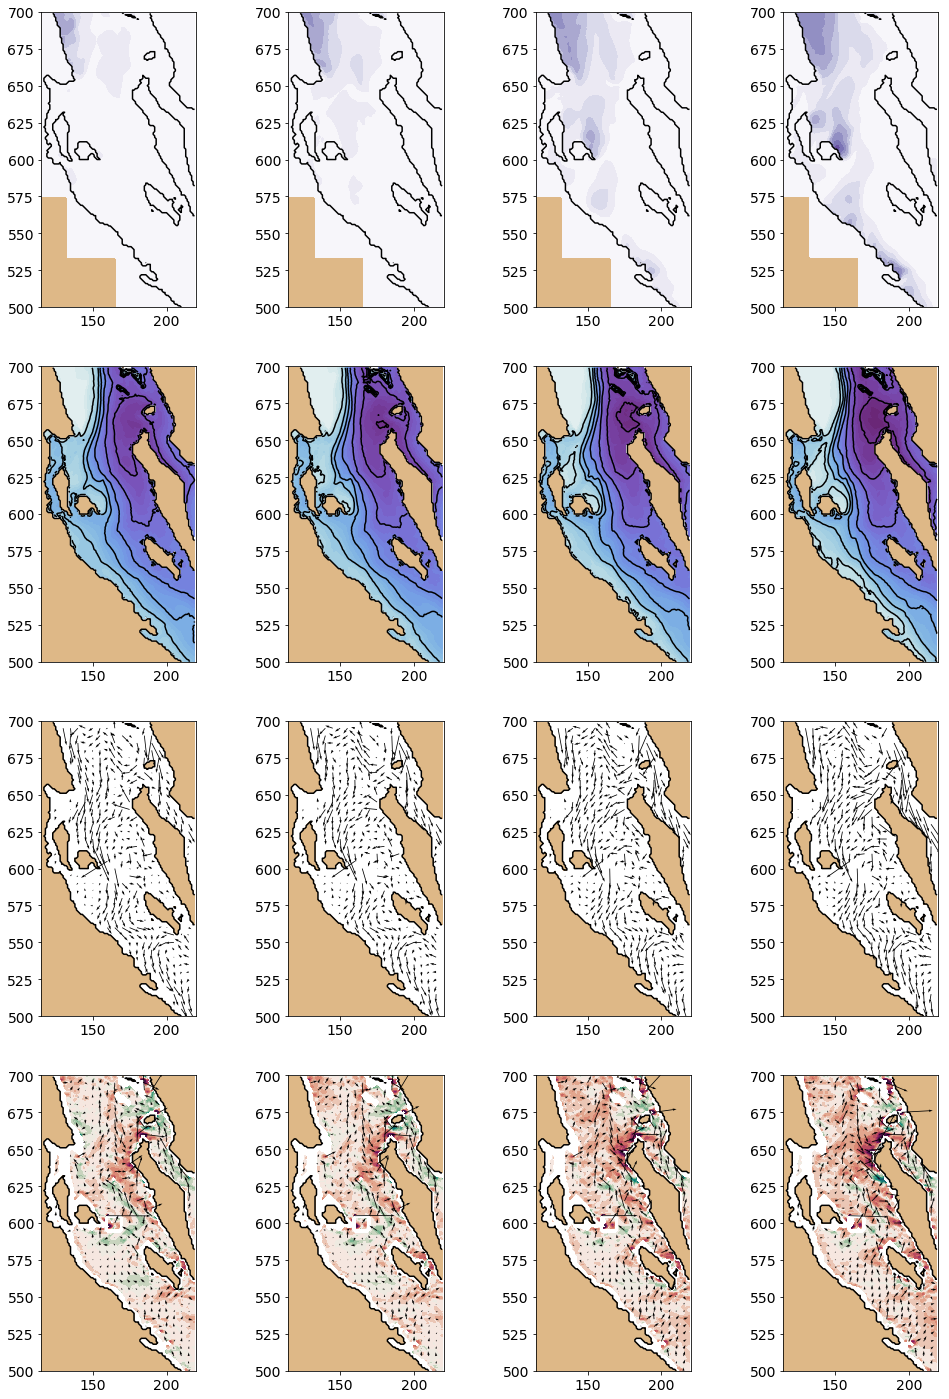

In [153]:
# Make figure layout
fig, axs = plt.subplots(4, 4, figsize=(17, 25))

# Loop through time indices
for ax, t in zip(axs.T, [20, 25, 30, 35]):
    
    # Plot coastline and frame
    for qty in ax:
        qty.contourf(x, y, tmask[0, ...], levels=[-0.01, 0.01], colors='Burlywood')
        qty.contour(x, y, tmask[0, ...], levels=[-0.01, 0.01], colors='k')
        qty.set_xlim([115, 220])
        qty.set_ylim([500, 700])
        qty.set_aspect(1)
    
    # Mask rho = 1022 land points
    depth_1022_plot = np.ma.masked_where(depth_1022_filt[t, ...] > 100, depth_1022_filt[t, ...])
    index = (tmask[20, ...] == 0)  | (abs(u_g_filt[t, ...]) > 0.2) | (abs(v_g_filt[t, ...]) > 0.2)
    u_g_plot, v_g_plot = np.ma.masked_where(index, u_g_filt[t, ...]), np.ma.masked_where(index, v_g_filt[t, ...])
    u_a_plot, v_a_plot = np.ma.masked_where(index, u_a_filt[t, ...]), np.ma.masked_where(index, v_a_filt[t, ...])
    
    # Plot model fields
    ax[0].contourf(x, y, tracer[t, ...], cmap='Purples', levels=np.arange(0, 1.1, 0.1))
    ax[1].contourf(x, y, depth_1022_plot, levels=range(40), cmap=cmocean.cm.dense)
    ax[1].contour(x, y, depth_1022_plot, levels=range(0, 33, 4), colors='k')
    ax[2].quiver(x[::5], y[::5], u_g_plot[::5, ::5], v_g_plot[::5, ::5], scale=1, width=0.005)
    ax[3].contourf(x, y, u_a_plot, levels=np.arange(-0.1, 0.11, 0.01), cmap=cmocean.cm.curl)
    ax[3].quiver(x[::5], y[::5], u_a_plot[::5, ::5], v_a_plot[::5, ::5], scale=0.8, width=0.005)
    
    #plt.quiverkey(q, 0.2, 0.05, 0.1, '0.1 m/s')